In [11]:
from sbi import utils as utils
from sbi.utils import process_prior, posterior_nn
from sbi import inference as Inference
from scipy import optimize, stats

import os
import emcee
import torch
import pickle
from torch.distributions import Distribution, Normal, constraints
import numpy as np
import matplotlib.pyplot as plt
import torch.distributions as dist
import torch

from models.lightcurves import LightCurve
from interpolate_lcs import ugrizy_to_numbers
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from models.custom_sklearn import train_test_split, StandardScaler
from KDEpy import FFTKDE

# Note that we are lazily using the CPU, but this is faster w/ a GPU
if torch.cuda.is_available(): device = 'mps'
else: device = 'cpu'
print(f'device is {device}')
torch.set_default_dtype(torch.float32)

import sys
sys.path.append('/Users/adamboesky/Research/SBI_205/models')

# matplotlib formatting
import matplotlib as mpl
plt.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cmr10'  # Computer Modern Roman
mpl.rcParams['font.size'] = 12  # Adjust the font size as needed
plt.rc('text', usetex=True)

device is cpu


# Load data

## SBI

In [12]:
# Load our data
print('Loading data!!!')
with open('data/full_encoded_lcs.pkl', 'rb') as f:
    encoded_lcs, lcs = pickle.load(f)

# Filter for snr > 3
encoded_lcs     = np.array([e_lc for e_lc, lc in zip(encoded_lcs, lcs) if np.mean(lc.snrs) > 3])
lcs             = np.array([lc   for e_lc, lc in zip(encoded_lcs, lcs) if np.mean(lc.snrs) > 3])

# Split into test and train
print('Preprocessing data!!!')
predictor_mask = np.array([ True,  True, False, False, False, False, False,  True,  True, False,  True])  # mask for theta that only gets what we actually care about
all_predictor_labels = np.array(['pspin', 'bfield', 'mns', 'thetapb', 'texp', 'kappa', 'kappagamma', 'mej', 'vej', 'tfloor', 'texplosion'])
predictor_labels = all_predictor_labels[predictor_mask]
print(f'theta = {predictor_labels}')
X_encoded = np.array([np.concatenate((lc_encoding, [lc.redshift])) for lc_encoding, lc in zip(encoded_lcs, lcs)])
X_not_encoded = np.array([np.concatenate((lc.mags_interped, lc.magerrs_interped, [lc.redshift])) for lc in lcs])
y = np.array([np.array(lc.theta)[predictor_mask] for lc in lcs])

# Preprocess the data
y[:, -1] *= -1  # multiply the explosion time by negative because they're all negative
y[:, 1] = np.log10(y[:, 1])
y[:, 2] = np.log10(y[:, 2])
y_means = np.mean(y, axis=0)
y_stds = np.std(y, axis=0)
y_norm = np.copy(y)
y_norm[:, :-1] -= y_means[:-1]
y_norm[:, :-1] /= y_stds[:-1]

# Train test split
X_train, X_test, X_train_NE, X_test_NE, y_train, y_test, lcs_train, lcs_test = train_test_split(X_encoded, X_not_encoded, y_norm, lcs, random_state=22, test_size=0.2)

Loading data!!!
Preprocessing data!!!
theta = ['pspin' 'bfield' 'mej' 'vej' 'texplosion']


In [13]:
X_encoded.shape, X_not_encoded.shape

((12525, 26), (12525, 1201))

/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.py:901: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  return fig.subplots(K, K), True
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.py:290: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[i])
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.py:290: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[i])
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.py:799: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[0])
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.py:800: UserWarnin

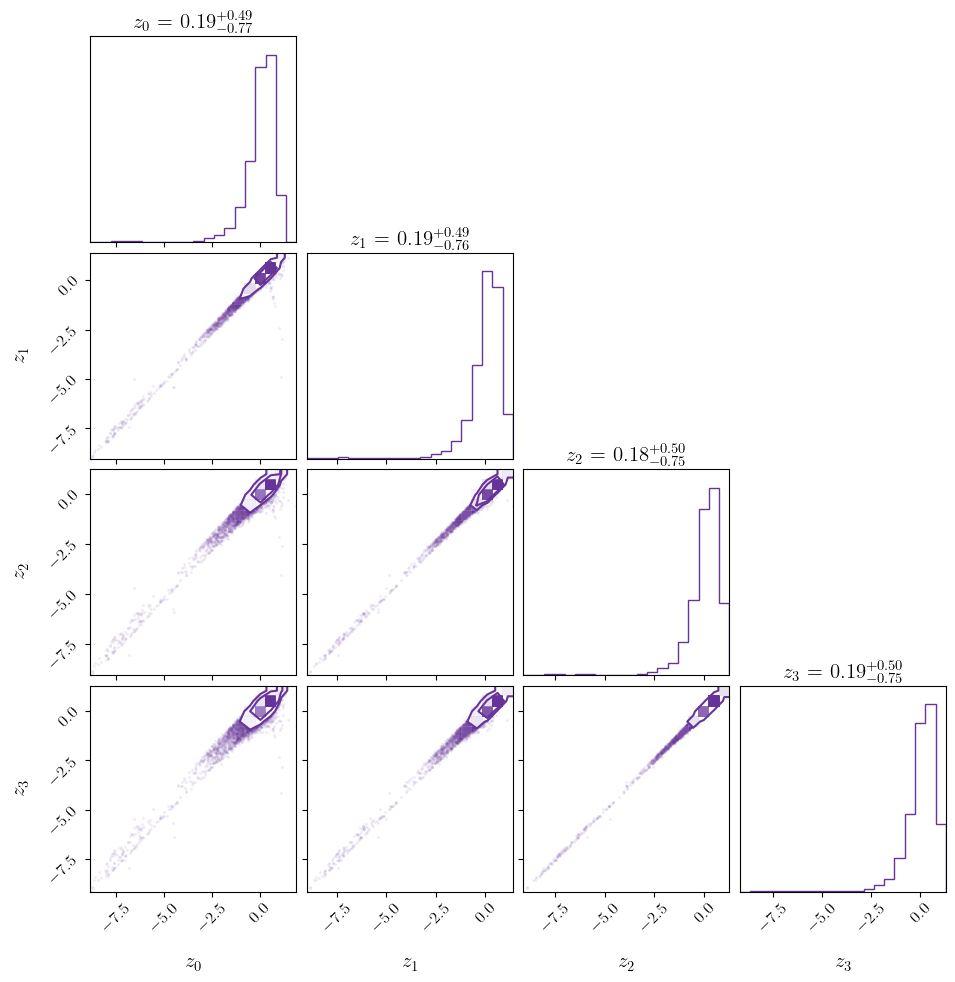

In [14]:
from corner import corner
from autoencode import Encoder, Decoder, Autoencoder

# Get the autoencoder
autoencoder = torch.load('models/tuned_states/autoencoder0.pkl')

# Plot the latent space values
latent_space = autoencoder.decoder(torch.Tensor(encoded_lcs)).detach().numpy()[:, :4]
fig = plt.figure(figsize=(10, 10))
figure = corner(latent_space,
                fig=fig,
                labels=[rf"$z_{i}$" for i in range(latent_space.shape[1])],
                show_titles=True,
                label_kwargs={"fontsize": 15},
                title_kwargs={"fontsize": 15},
                color='rebeccapurple')

In [44]:
with open('data/sbi_results_7blocks.pkl', 'rb') as f:
    hatp_x_y, p_x_y_estimator = pickle.load(f)
hatp_x_y
with open('data/sbi_results_7blocks_full_lc.pkl', 'rb') as f:
    hatp_x_y_NE, p_x_y_estimator_NE = pickle.load(f)
hatp_x_y_NE
with open('data/sbi_results_7blocks_200units.pkl', 'rb') as f:
    hatp_x_y_big, p_x_y_estimator_big = pickle.load(f)
hatp_x_y_big
with open('data/sbi_results_7blocks_200units_full_lc.pkl', 'rb') as f:
    hatp_x_y_NE_big, p_x_y_estimator_NE_big = pickle.load(f)
hatp_x_y_NE_big

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

In [46]:
sbi_samples = []
for i, X_i in enumerate(X_test[:250]):
    sbi_samples.append(hatp_x_y.sample((500,), x=X_i).numpy())
    if i%100==0:
        print(f'Done with {i} / {X_test.shape[0]}')
sbi_samples_NE = []
for i, X_i in enumerate(X_test_NE[:250]):
    sbi_samples_NE.append(hatp_x_y_NE.sample((500,), x=X_i).numpy())
    if i%100==0:
        print(f'Done with {i} / {X_test_NE.shape[0]}')
sbi_samples_big = []
for i, X_i in enumerate(X_test[:250]):
    sbi_samples_big.append(hatp_x_y_big.sample((500,), x=X_i).numpy())
    if i%100==0:
        print(f'Done with {i} / {X_test.shape[0]}')
sbi_samples_NE_big = []
for i, X_i in enumerate(X_test_NE[:250]):
    sbi_samples_NE_big.append(hatp_x_y_NE_big.sample((500,), x=X_i).numpy())
    if i%100==0:
        print(f'Done with {i} / {X_test.shape[0]}')

Drawing 500 posterior samples: 581it [00:00, 7376.76it/s]             


Done with 0 / 2505


Drawing 500 posterior samples: 540it [00:00, 9748.70it/s]             
Drawing 500 posterior samples: 539it [00:00, 11397.57it/s]            
Drawing 500 posterior samples: 536it [00:00, 16979.71it/s]            
Drawing 500 posterior samples: 527it [00:00, 19360.76it/s]            
Drawing 500 posterior samples: 571it [00:00, 21843.94it/s]            
Drawing 500 posterior samples: 562it [00:00, 18102.22it/s]            
Drawing 500 posterior samples: 584it [00:00, 18956.28it/s]            
Drawing 500 posterior samples: 562it [00:00, 12867.23it/s]            
Drawing 500 posterior samples: 546it [00:00, 18623.92it/s]            
Drawing 500 posterior samples: 561it [00:00, 21530.70it/s]            
Drawing 500 posterior samples: 547it [00:00, 19430.90it/s]            
Drawing 500 posterior samples: 566it [00:00, 18661.43it/s]            
Drawing 500 posterior samples: 559it [00:00, 20726.62it/s]            
Drawing 500 posterior samples: 667it [00:00, 13561.82it/s]            
Drawin

Done with 100 / 2505


Drawing 500 posterior samples: 592it [00:00, 12896.57it/s]            
Drawing 500 posterior samples: 563it [00:00, 14034.03it/s]            
Drawing 500 posterior samples: 558it [00:00, 15741.02it/s]            
Drawing 500 posterior samples: 560it [00:00, 15169.96it/s]            
Drawing 500 posterior samples: 568it [00:00, 14886.24it/s]            
Drawing 500 posterior samples: 541it [00:00, 16072.52it/s]            
Drawing 500 posterior samples: 528it [00:00, 15051.23it/s]            
Drawing 500 posterior samples: 552it [00:00, 15232.55it/s]            
Drawing 500 posterior samples: 585it [00:00, 17680.14it/s]            
Drawing 500 posterior samples: 665it [00:00, 13400.46it/s]            
Drawing 500 posterior samples: 532it [00:00, 16197.75it/s]            
Drawing 500 posterior samples: 551it [00:00, 19451.41it/s]            
Drawing 500 posterior samples: 549it [00:00, 16875.70it/s]            
Drawing 500 posterior samples: 567it [00:00, 15513.38it/s]            
Drawin

Done with 200 / 2505


Drawing 500 posterior samples: 625it [00:00, 13312.34it/s]            
Drawing 500 posterior samples: 530it [00:00, 18938.17it/s]            
Drawing 500 posterior samples: 557it [00:00, 18104.54it/s]            
Drawing 500 posterior samples: 554it [00:00, 12371.33it/s]            
Drawing 500 posterior samples: 569it [00:00, 14351.62it/s]            
Drawing 500 posterior samples: 582it [00:00, 15458.12it/s]            
Drawing 500 posterior samples: 554it [00:00, 16369.57it/s]            
Drawing 500 posterior samples: 553it [00:00, 19019.06it/s]            
Drawing 500 posterior samples: 594it [00:00, 15560.36it/s]            
Drawing 500 posterior samples: 569it [00:00, 17135.10it/s]            
Drawing 500 posterior samples: 571it [00:00, 14564.88it/s]            
Drawing 500 posterior samples: 597it [00:00, 13812.73it/s]            
Drawing 500 posterior samples: 532it [00:00, 15386.00it/s]            
Drawing 500 posterior samples: 555it [00:00, 16563.18it/s]            
Drawin

Done with 0 / 2505


Drawing 500 posterior samples: 543it [00:00, 14435.25it/s]            
Drawing 500 posterior samples: 537it [00:00, 15858.88it/s]            
Drawing 500 posterior samples: 571it [00:00, 15909.78it/s]            
Drawing 500 posterior samples: 544it [00:00, 15801.58it/s]            
Drawing 500 posterior samples: 550it [00:00, 16837.59it/s]            
Drawing 500 posterior samples: 588it [00:00, 9310.58it/s]             
Drawing 500 posterior samples: 537it [00:00, 10871.58it/s]            
Drawing 500 posterior samples: 595it [00:00, 7053.61it/s]             
Drawing 500 posterior samples: 576it [00:00, 5704.78it/s]             
Drawing 500 posterior samples: 536it [00:00, 8698.74it/s]             
Drawing 500 posterior samples: 550it [00:00, 11158.25it/s]            
Drawing 500 posterior samples: 526it [00:00, 12173.97it/s]            
Drawing 500 posterior samples: 538it [00:00, 15298.03it/s]            
Drawing 500 posterior samples: 648it [00:00, 4328.80it/s]             
Drawin

Done with 100 / 2505


Drawing 500 posterior samples: 541it [00:00, 6002.10it/s]             
Drawing 500 posterior samples: 656it [00:00, 14001.79it/s]            
Drawing 500 posterior samples: 589it [00:00, 16198.26it/s]            
Drawing 500 posterior samples: 554it [00:00, 13846.79it/s]            
Drawing 500 posterior samples: 582it [00:00, 13210.55it/s]            
Drawing 500 posterior samples: 587it [00:00, 15724.25it/s]            
Drawing 500 posterior samples: 542it [00:00, 14290.55it/s]            
Drawing 500 posterior samples: 537it [00:00, 16500.67it/s]            
Drawing 500 posterior samples: 564it [00:00, 14716.67it/s]            
Drawing 500 posterior samples: 749it [00:00, 3040.98it/s]             
Drawing 500 posterior samples: 537it [00:00, 14780.31it/s]            
Drawing 500 posterior samples: 562it [00:00, 7436.71it/s]             
Drawing 500 posterior samples: 532it [00:00, 15779.88it/s]            
Drawing 500 posterior samples: 543it [00:00, 16468.47it/s]            
Drawin

Done with 200 / 2505


Drawing 500 posterior samples: 640it [00:00, 8038.00it/s]             
Drawing 500 posterior samples: 596it [00:00, 15725.21it/s]            
Drawing 500 posterior samples: 579it [00:00, 16533.81it/s]            
Drawing 500 posterior samples: 540it [00:00, 16586.78it/s]            
Drawing 500 posterior samples: 541it [00:00, 17828.33it/s]            
Drawing 500 posterior samples: 539it [00:00, 16940.65it/s]            
Drawing 500 posterior samples: 533it [00:00, 14137.51it/s]            
Drawing 500 posterior samples: 537it [00:00, 17598.34it/s]            
Drawing 500 posterior samples: 556it [00:00, 17167.88it/s]            
Drawing 500 posterior samples: 551it [00:00, 16506.29it/s]            
Drawing 500 posterior samples: 555it [00:00, 17983.23it/s]            
Drawing 500 posterior samples: 605it [00:00, 15951.73it/s]            
Drawing 500 posterior samples: 544it [00:00, 16655.00it/s]            
Drawing 500 posterior samples: 558it [00:00, 17345.45it/s]            
Drawin

Done with 0 / 2505


Drawing 500 posterior samples: 550it [00:00, 8708.18it/s]             
Drawing 500 posterior samples: 532it [00:00, 9796.85it/s]             
Drawing 500 posterior samples: 530it [00:00, 9903.02it/s]             
Drawing 500 posterior samples: 534it [00:00, 10542.32it/s]            
Drawing 500 posterior samples: 555it [00:00, 10814.68it/s]            
Drawing 500 posterior samples: 550it [00:00, 10073.30it/s]            
Drawing 500 posterior samples: 561it [00:00, 9468.98it/s]             
Drawing 500 posterior samples: 583it [00:00, 7201.42it/s]             
Drawing 500 posterior samples: 572it [00:00, 9384.59it/s]             
Drawing 500 posterior samples: 548it [00:00, 7955.88it/s]             
Drawing 500 posterior samples: 549it [00:00, 11209.53it/s]            
Drawing 500 posterior samples: 537it [00:00, 10135.09it/s]            
Drawing 500 posterior samples: 577it [00:00, 11638.46it/s]            
Drawing 500 posterior samples: 685it [00:00, 7157.35it/s]             
Drawin

Done with 100 / 2505


Drawing 500 posterior samples: 559it [00:00, 8080.01it/s]             
Drawing 500 posterior samples: 565it [00:00, 8120.03it/s]             
Drawing 500 posterior samples: 533it [00:00, 11064.52it/s]            
Drawing 500 posterior samples: 530it [00:00, 10711.20it/s]            
Drawing 500 posterior samples: 559it [00:00, 10263.69it/s]            
Drawing 500 posterior samples: 553it [00:00, 11296.54it/s]            
Drawing 500 posterior samples: 535it [00:00, 11100.71it/s]            
Drawing 500 posterior samples: 560it [00:00, 10973.75it/s]            
Drawing 500 posterior samples: 559it [00:00, 9178.81it/s]             
Drawing 500 posterior samples: 704it [00:00, 3874.35it/s]             
Drawing 500 posterior samples: 557it [00:00, 7081.82it/s]             
Drawing 500 posterior samples: 555it [00:00, 6290.74it/s]             
Drawing 500 posterior samples: 540it [00:00, 4914.19it/s]             
Drawing 500 posterior samples: 551it [00:00, 6359.36it/s]             
Drawin

Done with 200 / 2505


Drawing 500 posterior samples: 582it [00:00, 6178.48it/s]             
Drawing 500 posterior samples: 553it [00:00, 8910.58it/s]             
Drawing 500 posterior samples: 546it [00:00, 8413.82it/s]             
Drawing 500 posterior samples: 536it [00:00, 10426.43it/s]            
Drawing 500 posterior samples: 573it [00:00, 11188.35it/s]            
Drawing 500 posterior samples: 530it [00:00, 7916.12it/s]             
Drawing 500 posterior samples: 563it [00:00, 9857.46it/s]             
Drawing 500 posterior samples: 541it [00:00, 8254.10it/s]             
Drawing 500 posterior samples: 531it [00:00, 9480.93it/s]             
Drawing 500 posterior samples: 553it [00:00, 8700.31it/s]             
Drawing 500 posterior samples: 573it [00:00, 9711.00it/s]             
Drawing 500 posterior samples: 683it [00:00, 3922.18it/s]             
Drawing 500 posterior samples: 551it [00:00, 1604.45it/s]                         
Drawing 500 posterior samples: 548it [00:01, 315.50it/s]         

Done with 0 / 2505


Drawing 500 posterior samples: 549it [00:00, 1147.08it/s]                         
Drawing 500 posterior samples: 576it [00:00, 1181.79it/s]                         
Drawing 500 posterior samples: 535it [00:00, 1326.89it/s]                         
Drawing 500 posterior samples: 570it [00:00, 1449.72it/s]                         
Drawing 500 posterior samples: 589it [00:00, 1509.73it/s]                         
Drawing 500 posterior samples: 559it [00:00, 1349.43it/s]                         
Drawing 500 posterior samples: 565it [00:00, 1358.28it/s]                         
Drawing 500 posterior samples: 586it [00:00, 1326.04it/s]                         
Drawing 500 posterior samples: 571it [00:00, 1319.29it/s]                         
Drawing 500 posterior samples: 558it [00:00, 1453.11it/s]                         
Drawing 500 posterior samples: 582it [00:00, 1609.02it/s]                         
Drawing 500 posterior samples: 560it [00:00, 1632.54it/s]                         
Draw

Done with 100 / 2505


Drawing 500 posterior samples: 591it [00:00, 1225.55it/s]                         
Drawing 500 posterior samples: 597it [00:01, 443.36it/s]                          
Drawing 500 posterior samples: 595it [00:03, 185.31it/s]                         
Drawing 500 posterior samples: 589it [00:02, 273.31it/s]                         
Drawing 500 posterior samples: 526it [00:01, 480.47it/s]                         
Drawing 500 posterior samples: 560it [00:01, 500.00it/s]                         
Drawing 500 posterior samples: 559it [00:00, 710.60it/s]                         
Drawing 500 posterior samples: 542it [00:00, 811.85it/s]                         
Drawing 500 posterior samples: 558it [00:01, 460.27it/s]                         
Drawing 500 posterior samples: 642it [00:01, 630.39it/s]                         
Drawing 500 posterior samples: 558it [00:00, 1131.61it/s]                         
Drawing 500 posterior samples: 566it [00:00, 1261.26it/s]                         
Drawing 500 

Done with 200 / 2505


Drawing 500 posterior samples: 637it [00:00, 1856.67it/s]             
Drawing 500 posterior samples: 581it [00:00, 4936.79it/s]             
Drawing 500 posterior samples: 574it [00:00, 4785.45it/s]             
Drawing 500 posterior samples: 552it [00:00, 4574.98it/s]             
Drawing 500 posterior samples: 587it [00:00, 7665.11it/s]             
Drawing 500 posterior samples: 530it [00:00, 4207.01it/s]             
Drawing 500 posterior samples: 558it [00:00, 829.10it/s]                          
Drawing 500 posterior samples: 559it [00:01, 404.66it/s]                          
Drawing 500 posterior samples: 545it [00:01, 359.18it/s]                         
Drawing 500 posterior samples: 546it [00:01, 537.80it/s]                         
Drawing 500 posterior samples: 573it [00:00, 853.66it/s]                          
Drawing 500 posterior samples: 565it [00:01, 497.23it/s]                         
Drawing 500 posterior samples: 550it [00:00, 922.55it/s]                       

In [19]:
sbi_samples = np.asarray(sbi_samples)
sbi_samples.shape

(1000, 500, 5)

In [31]:
# Grab the median posterior
sbi_median_posterior = np.median(sbi_samples, axis=1)
sbi_posterior_std = np.std(sbi_samples, axis=1)
sbi_median_posterior.shape

# Retransform
sbi_median_posterior[:, :-1] *= y_stds[:-1]
sbi_median_posterior[:, :-1] += y_means[:-1]

# Run a KDE on the posterior
sbi_post_xs = []
sbi_post_ys = []
for i in range(5):

    # Compute kernel density estimate on a grid using Silverman's rule for bw
    x_kde, y_kde = FFTKDE(bw="silverman").fit(sbi_median_posterior[:, i]).evaluate()
    sbi_post_xs.append(x_kde)
    sbi_post_ys.append(y_kde)

In [32]:

# Grab the median posterior
sbi_median_posterior_NE = np.median(sbi_samples_NE, axis=1)
sbi_posterior_std_NE = np.std(sbi_samples_NE, axis=1)
sbi_median_posterior_NE.shape

# Retransform
sbi_median_posterior_NE[:, :-1] *= y_stds[:-1]
sbi_median_posterior_NE[:, :-1] += y_means[:-1]

# Run a KDE on the posterior
sbi_post_xs_NE = []
sbi_post_ys_NE = []
for i in range(5):

    # Compute kernel density estimate on a grid using Silverman's rule for bw
    x_kde_NE, y_kde_NE = FFTKDE(bw="silverman").fit(sbi_median_posterior_NE[:, i]).evaluate()
    sbi_post_xs_NE.append(x_kde_NE)
    sbi_post_ys_NE.append(y_kde_NE)

In [39]:
# Grab the median posterior
sbi_median_posterior_big = np.median(sbi_samples_big, axis=1)
sbi_posterior_std_big = np.std(sbi_samples_big, axis=1)
sbi_median_posterior_big.shape

# Retransform
sbi_median_posterior_big[:, :-1] *= y_stds[:-1]
sbi_median_posterior_big[:, :-1] += y_means[:-1]

# Run a KDE on the posterior
sbi_post_xs_big = []
sbi_post_ys_big = []
for i in range(5):

    # Compute kernel density estimate on a grid using Silverman's rule for bw
    x_kde_big, y_kde_big = FFTKDE(bw="silverman").fit(sbi_median_posterior_big[:, i]).evaluate()
    sbi_post_xs_big.append(x_kde_big)
    sbi_post_ys_big.append(y_kde_big)

In [79]:
# Grab the median posterior
sbi_median_posterior_NE_big = np.median(sbi_samples_NE_big, axis=1)
sbi_posterior_std_NE_big = np.std(sbi_samples_NE_big, axis=1)
sbi_median_posterior_NE_big.shape

# Retransform
sbi_median_posterior_NE_big[:, :-1] *= y_stds[:-1]
sbi_median_posterior_NE_big[:, :-1] += y_means[:-1]

# Run a KDE on the posterior
sbi_post_xs_NE_big = []
sbi_post_ys_NE_big = []
for i in range(5):

    # Compute kernel density estimate on a grid using Silverman's rule for bw
    x_kde_NE_big, y_kde_NE_big = FFTKDE(bw="silverman").fit(sbi_median_posterior_NE_big[:, i]).evaluate()
    sbi_post_xs_NE_big.append(x_kde_NE_big)
    sbi_post_ys_NE_big.append(y_kde_NE_big)

Drawing 500 posterior samples: 580it [00:00, 2845.01it/s]                         
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_65636/948722491.py:12: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(5, 5, figsize=(15, 10))
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.py:290: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[i])
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.py:290: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[i])
/Users/adamboesky/opt/anaconda3/envs/sbi2/lib/python3.12/site-packages/corner/core.py:799: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax.set_xscale(axes_scale[0])
/Users/ada

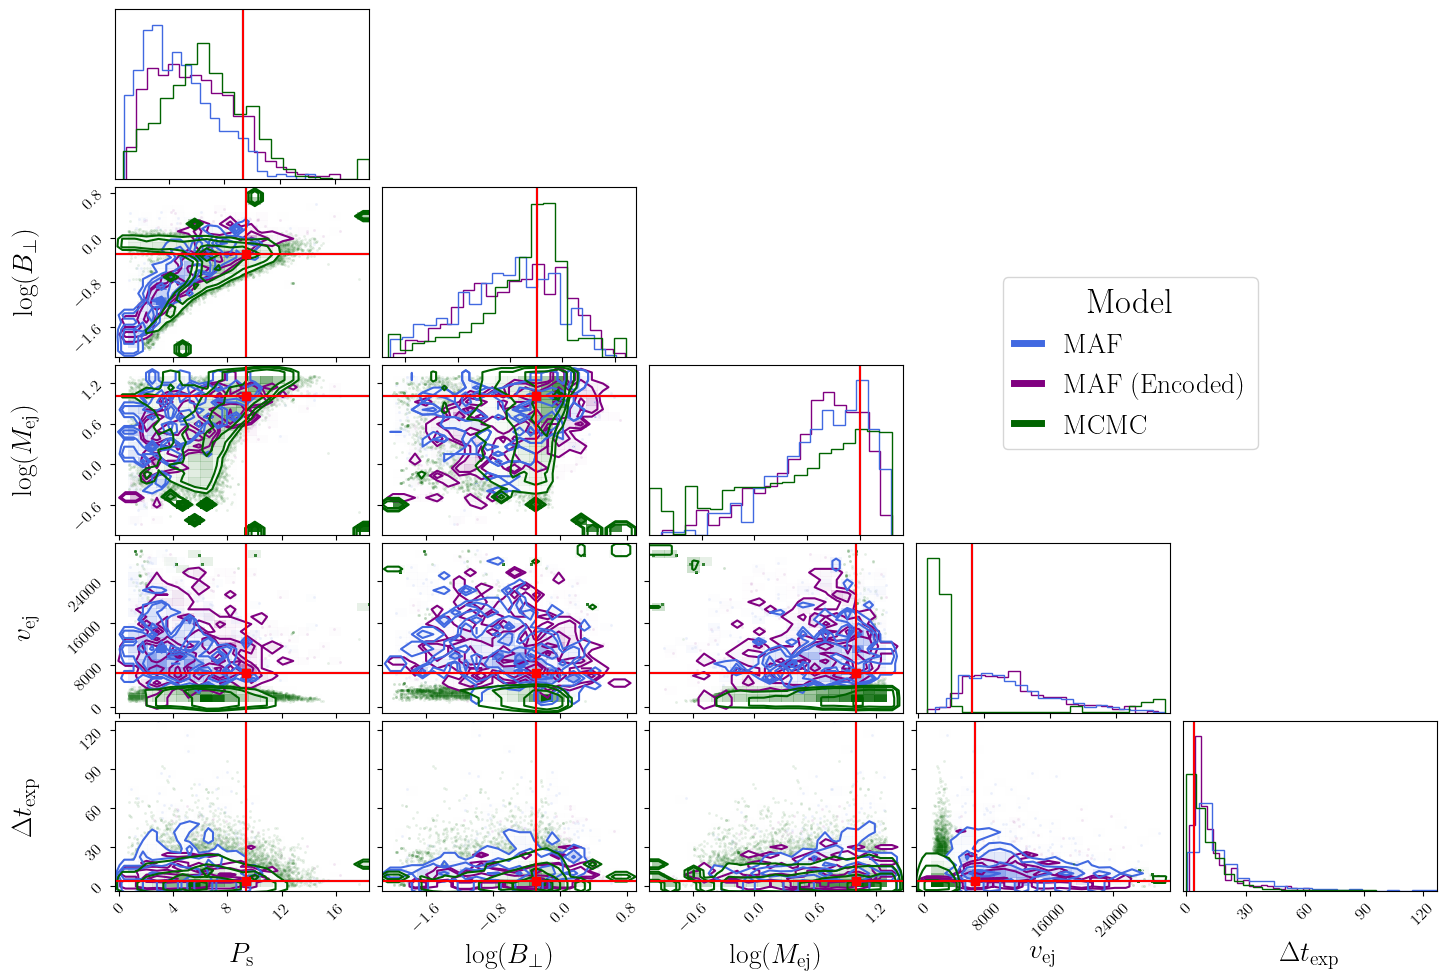

In [87]:
import corner

ind = 190

# Compressed SBI
demo_post = hatp_x_y_big.sample((500,), x=np.copy(X_test[ind])).numpy()
demo_post[:,:-1] *= y_stds[:-1]
demo_post[:,:-1] += y_means[:-1]
y_test_retrans = np.copy(y_test[ind])
y_test_retrans[:-1] *= y_stds[:-1]
y_test_retrans[:-1] += y_means[:-1]
fig, axes = plt.subplots(5, 5, figsize=(15, 10))
fig = corner.corner(
    demo_post,
    labels=[r'$P_{\rm{s}}$', r'$\log(B_{\perp})$', r'$\log(M_{\rm{ej}})$', r'$v_{\rm{ej}}$', r'$\Delta t_{\rm{exp}}$'],
    truths=y_test_retrans,
    label_kwargs={"fontsize": 20},
    fig=fig,
    fill_contour=False,
    hist_kwargs={'density': True},
    color='purple'
)

# Non-compressed SBI
demo_post = hatp_x_y_NE_big.sample((500,), x=np.copy(X_test_NE[ind])).numpy()
demo_post[:,:-1] *= y_stds[:-1]
demo_post[:,:-1] += y_means[:-1]
y_test_retrans = np.copy(y_test[ind])
y_test_retrans[:-1] *= y_stds[:-1]
y_test_retrans[:-1] += y_means[:-1]
fig = corner.corner(
    demo_post,
    labels=[r'$P_{\rm{s}}$', r'$\log(B_{\perp})$', r'$\log(M_{\rm{ej}})$', r'$v_{\rm{ej}}$', r'$\Delta t_{\rm{exp}}$'],
    truths=y_test_retrans,
    label_kwargs={"fontsize": 20},
    fig=fig,
    color='royalblue',
    fill_contour=False,
    hist_kwargs={'density': True},
)



# MCMC
with open(f'/Users/adamboesky/Research/SBI_205/data/mcmc_results_final/mcmc_results{ind}.pkl', 'rb') as f:
    final_results, sampler = pickle.load(f)
# Get samples
samples = sampler.get_chain(discard=100, thin=15, flat=True)
true = np.copy(lcs_test[ind].theta)[[ True,  True, False, False, False, False, False,  True,  True, False, True]]
true[1] = np.log10(true[1])
true[2] = np.log10(true[2])
# true[3] = true[3] / 1000
samples[:, 3] *= 1000
true[-1] *= -1
corner.corner(samples[:, :-1],
              truths=true,
              fig=fig,
              truth_color='red',
              hist_kwargs={'density': True},
              fill_contour=False,
              color='darkgreen'
)
legend_elements = [plt.Line2D([0], [0], color=col, lw=5, label=model_name) for model_name, col in zip(['MAF', 'MAF (Encoded)', 'MCMC'], ['royalblue', 'purple', 'darkgreen'])]

plt.legend(handles=legend_elements, fontsize='20', bbox_to_anchor=(0.35, 3.7), frameon=True, title='Model', title_fontsize='25', handlelength=1)

plt.savefig('Figures/example_SN_post.pdf')
plt.show()

## MCMC

In [21]:
def log_likelihood(xs, y, yerr, filts, theta, z, dist_const):
    pass
def log_probability(theta, ts, y, yerr, filts, z, dist_const):
    pass

In [34]:
# Iterate through dir and get samples
all_samples = []
for i, filename in enumerate(os.listdir('/Users/adamboesky/Research/SBI_205/data/mcmc_results_final')[:250]):

    # Load sampler
    with open(f'/Users/adamboesky/Research/SBI_205/data/mcmc_results/{filename}', 'rb') as f:
        p0_mcmc, mcmc_sampler = pickle.load(f)

    # Generate a few samples
    all_samples.append(mcmc_sampler.get_chain(discard=100, thin=15, flat=True))

    if i%100==0:
        print(f'Done with lc {i}')
all_samples = np.asarray(all_samples)

Done with lc 0
Done with lc 100
Done with lc 200


In [58]:
# Grab the median posterior
mcmc_median_posterior = np.median(all_samples, axis=1)
mcmc_posterior_std = np.std(all_samples, axis=1)
mcmc_median_posterior.shape

# Run a KDE on the posterior
mcmc_post_xs = []
mcmc_post_ys = []
for i in range(5):

    # Compute kernel density estimate on a grid using Silverman's rule for bw
    x_kde, y_kde = FFTKDE(bw='silverman').fit(mcmc_median_posterior[:, i]).evaluate()
    mcmc_post_xs.append(x_kde)
    mcmc_post_ys.append(y_kde)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_65636/1205133707.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(1, 5, figsize=(20, 4))
Drawing 500 posterior samples: 563it [00:00, 2541.89it/s]                         


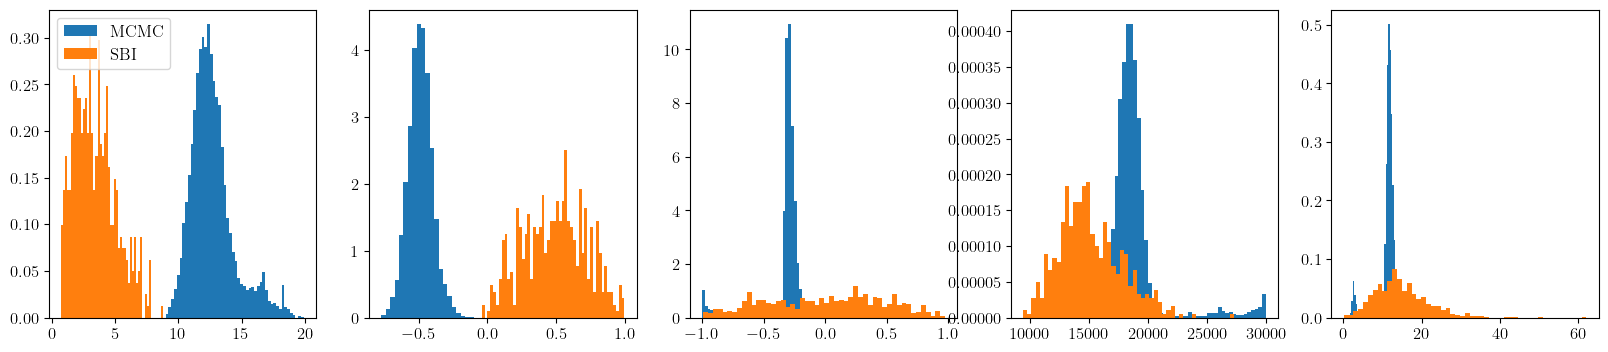

In [36]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
samps = hatp_x_y.sample((500,), x=X_test[0]).numpy()
samps[:, :-1] *= y_stds[:-1]
samps[:, :-1] += y_means[:-1]
for i, ax in enumerate(axes):
    ax.hist(all_samples[0][:, i], density=True, bins=50, label='MCMC')
    ax.hist(samps[:, i], density=True, bins=50, label='SBI')
axes[0].legend()

In [77]:
# Divide posterior stds
std_sbi_big_to_mcmc = sbi_posterior_std_big / mcmc_posterior_std[:, :-1]
std_sbi_big_NE_to_mcmc = sbi_posterior_std_NE_big / mcmc_posterior_std[:, :-1]

# Get a KDE of the log std
sbi_std_kde_xs = []
sbi_std_kde_ys = []
sbi_std_kde_xs_NE = []
sbi_std_kde_ys_NE = []
for i in range(5):

    # Compute kernel density estimate on a grid using Silverman's rule for bw
    x_kde, y_kde = FFTKDE(bw='silverman').fit(np.log10(std_sbi_big_to_mcmc[:, i])).evaluate()
    sbi_std_kde_xs.append(x_kde)
    sbi_std_kde_ys.append(y_kde)

    # Compute kernel density estimate on a grid using Silverman's rule for bw
    x_kde, y_kde = FFTKDE(bw='silverman').fit(np.log10(std_sbi_big_NE_to_mcmc[:, i])).evaluate()
    sbi_std_kde_xs_NE.append(x_kde)
    sbi_std_kde_ys_NE.append(y_kde)

In [72]:
np.trapz(sbi_std_kde_ys_NE, sbi_std_kde_xs_NE), np.trapz(sbi_std_kde_ys, sbi_std_kde_xs)

(array([0.99999463, 0.99999442, 0.99999554, 0.99999422, 0.99998882]),
 array([0.99999486, 0.99999462, 0.9999951 , 0.99999394, 0.99998845]))

# Plotting

In [24]:
# Retransform the y_test data
y_test_renorm = np.copy(y_test)
y_test_renorm[:, :-1] *= y_stds[:-1]
y_test_renorm[:, :-1] += y_means[:-1]

# Get the KDEs
true_post_xs = []
true_post_ys = []
for i in range(5):

    # Compute kernel density estimate on a grid using Silverman's rule for bw
    x_kde, y_kde = FFTKDE(bw='silverman').fit(y_test_renorm[:, i]).evaluate()
    true_post_xs.append(x_kde)
    true_post_ys.append(y_kde)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_65636/2538290007.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(1, 5, figsize=(25, 4))


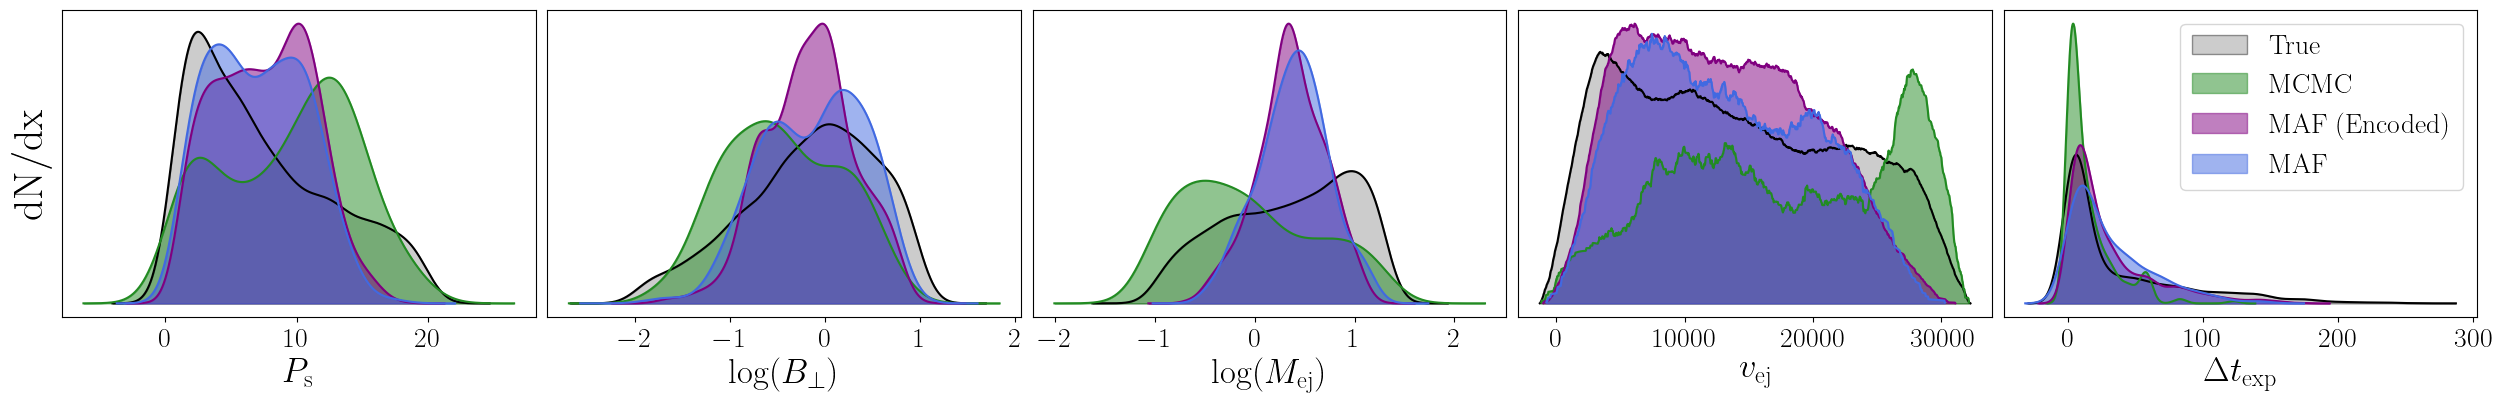

In [66]:
fig, axes = plt.subplots(1, 5, figsize=(25, 4))
for i, (ax, lab) in enumerate(zip(axes, [r'$P_{\rm{s}}$', r'$\log(B_{\perp})$', r'$\log(M_{\rm{ej}})$', r'$v_{\rm{ej}}$', r'$\Delta t_{\rm{exp}}$'])):

    # True data
    ax.fill_between(x=true_post_xs[i], y1=np.zeros((true_post_xs[i].shape[0])), y2=true_post_ys[i], ec='k', fc='gray', alpha=0.4, label='True')
    ax.plot(true_post_xs[i], true_post_ys[i], color='k')

    # Plot MCMC KDE
    ax.fill_between(x=mcmc_post_xs[i], y1=np.zeros((mcmc_post_xs[i].shape[0])), y2=mcmc_post_ys[i], ec='forestgreen', fc='forestgreen', alpha=0.5, label='MCMC')
    ax.plot(mcmc_post_xs[i], mcmc_post_ys[i], color='forestgreen')

    # Plot the compressed SBI KDE
    ax.fill_between(x=sbi_post_xs[i], y1=np.zeros((sbi_post_xs_big[i].shape[0])), y2=sbi_post_ys[i], ec='purple', fc='purple', alpha=0.5, label='MAF (Encoded)')
    ax.plot(sbi_post_xs[i], sbi_post_ys[i], color='purple')

    # Plot the SBI KDE
    ax.fill_between(x=sbi_post_xs_NE_big[i], y1=np.zeros((sbi_post_xs_NE_big[i].shape[0])), y2=sbi_post_ys_NE_big[i], ec='royalblue', fc='royalblue', alpha=0.5, label='MAF')
    ax.plot(sbi_post_xs_NE_big[i], sbi_post_ys_NE_big[i], color='royalblue')

    # # Plot the SBI KDE
    # ax.fill_between(x=sbi_post_xs_big[i], y1=np.zeros((sbi_post_xs_big[i].shape[0])), y2=sbi_post_ys_big[i], ec='orange', fc='orange', alpha=0.5, label='MAF (big)')
    # ax.plot(sbi_post_xs_big[i], sbi_post_ys_big[i], color='orange')

    # # Plot the SBI KDE
    # ax.fill_between(x=sbi_post_xs_NE_big[i], y1=np.zeros((sbi_post_xs_NE_big[i].shape[0])), y2=sbi_post_ys_NE_big[i], ec='pink', fc='pink', alpha=0.5, label='MAF (big Encoded)')
    # ax.plot(sbi_post_xs_NE_big[i], sbi_post_ys_NE_big[i], color='pink')

    # Formatting
    ax.set_xlabel(lab, fontsize=25)
    ax.set_yticklabels([])
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', length=0)

axes[4].legend(fontsize=20)
axes[0].set_ylabel(r'$\rm{d}N/\rm{d}x$', fontsize=30)
plt.savefig('Figures/SBI_vs_real_post.pdf', bbox_inches='tight')
plt.tight_layout(pad=0.5)
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_65636/1396716978.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(2, 5, figsize=(25, 8))


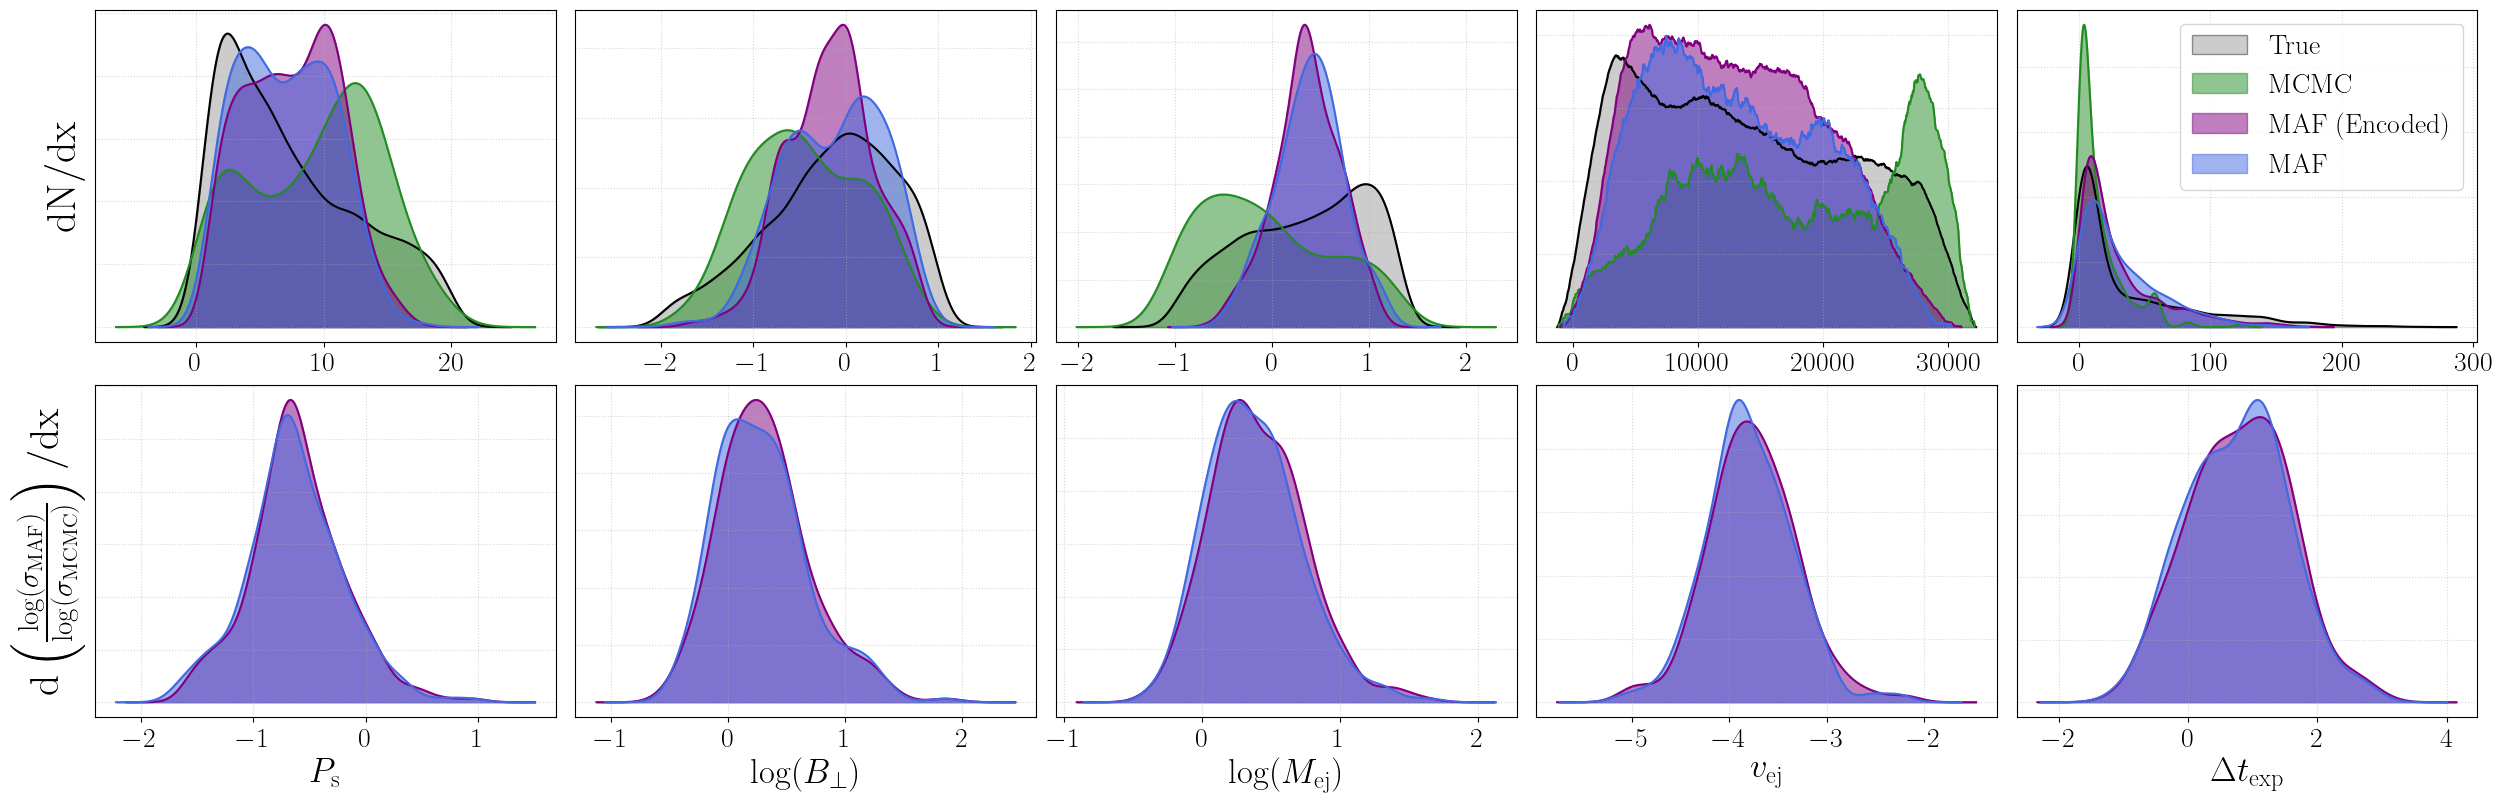

In [101]:
fig, axes = plt.subplots(2, 5, figsize=(25, 8))
for i, (ax, lab) in enumerate(zip(axes[0], [r'$P_{\rm{s}}$', r'$\log(B_{\perp})$', r'$\log(M_{\rm{ej}})$', r'$v_{\rm{ej}}$', r'$\Delta t_{\rm{exp}}$'])):

    # True data
    ax.fill_between(x=true_post_xs[i], y1=np.zeros((true_post_xs[i].shape[0])), y2=true_post_ys[i], ec='k', fc='gray', alpha=0.4, label='True')
    ax.plot(true_post_xs[i], true_post_ys[i], color='k')

    # Plot MCMC KDE
    ax.fill_between(x=mcmc_post_xs[i], y1=np.zeros((mcmc_post_xs[i].shape[0])), y2=mcmc_post_ys[i], ec='forestgreen', fc='forestgreen', alpha=0.5, label='MCMC')
    ax.plot(mcmc_post_xs[i], mcmc_post_ys[i], color='forestgreen')

    # Plot the compressed SBI KDE
    ax.fill_between(x=sbi_post_xs[i], y1=np.zeros((sbi_post_xs_big[i].shape[0])), y2=sbi_post_ys[i], ec='purple', fc='purple', alpha=0.5, label='MAF (Encoded)')
    ax.plot(sbi_post_xs[i], sbi_post_ys[i], color='purple')

    # Plot the SBI KDE
    ax.fill_between(x=sbi_post_xs_NE_big[i], y1=np.zeros((sbi_post_xs_NE_big[i].shape[0])), y2=sbi_post_ys_NE_big[i], ec='royalblue', fc='royalblue', alpha=0.5, label='MAF')
    ax.plot(sbi_post_xs_NE_big[i], sbi_post_ys_NE_big[i], color='royalblue')

    # # Plot the SBI KDE
    # ax.fill_between(x=sbi_post_xs_big[i], y1=np.zeros((sbi_post_xs_big[i].shape[0])), y2=sbi_post_ys_big[i], ec='orange', fc='orange', alpha=0.5, label='MAF (big)')
    # ax.plot(sbi_post_xs_big[i], sbi_post_ys_big[i], color='orange')

    # # Plot the SBI KDE
    # ax.fill_between(x=sbi_post_xs_NE_big[i], y1=np.zeros((sbi_post_xs_NE_big[i].shape[0])), y2=sbi_post_ys_NE_big[i], ec='pink', fc='pink', alpha=0.5, label='MAF (big Encoded)')
    # ax.plot(sbi_post_xs_NE_big[i], sbi_post_ys_NE_big[i], color='pink')

    # Formatting
    # ax.set_xlabel(lab, fontsize=25)
    ax.set_yticklabels([])
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', length=0)
    ax.grid(linestyle=':', alpha=0.5)

axes[0][4].legend(fontsize=20)
axes[0][0].set_ylabel(r'$\rm{d}N/\rm{d}x$', fontsize=30)


for i, (ax, lab) in enumerate(zip(axes[1], [r'$P_{\rm{s}}$', r'$\log(B_{\perp})$', r'$\log(M_{\rm{ej}})$', r'$v_{\rm{ej}}$', r'$\Delta t_{\rm{exp}}$'])):

    # Plot the compressed SBI KDE
    ax.fill_between(x=sbi_std_kde_xs[i], y1=np.zeros((sbi_std_kde_ys[i].shape[0])), y2=sbi_std_kde_ys[i], ec='purple', fc='purple', alpha=0.5, label='MAF (Encoded)')
    ax.plot(sbi_std_kde_xs[i], sbi_std_kde_ys[i], color='purple')

    # Plot the SBI KDE
    ax.fill_between(x=sbi_std_kde_xs_NE[i], y1=np.zeros((sbi_std_kde_ys_NE[i].shape[0])), y2=sbi_std_kde_ys_NE[i], ec='royalblue', fc='royalblue', alpha=0.5, label='MAF')
    ax.plot(sbi_std_kde_xs_NE[i], sbi_std_kde_ys_NE[i], color='royalblue')


    # Formatting
    ax.set_xlabel(lab, fontsize=25)
    ax.set_yticklabels([])
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', length=0)
    ax.grid(linestyle=':', alpha=0.5)

axes[1][0].set_ylabel(r'$\rm{d}\left( \frac{\log(\sigma_{\rm{MAF}})}{\log(\sigma_{\rm{MCMC}})} \right)/\rm{d}x$', fontsize=30)
plt.tight_layout(pad=0.5)
plt.savefig('Figures/SBI_vs_real_post_with_stds.pdf', bbox_inches='tight')
plt.show()

In [27]:
from scipy.stats import percentileofscore

all_percentile_sbi = []
for i, X_i in enumerate(X_test[:250]):
	samples = hatp_x_y.sample((2000,),x=X_i).numpy()
	percentiles_row = []
	for i_param in range(y_test.shape[1]):
		percentiles_row.append(percentileofscore(samples[:, i_param], y_test[i][i_param]))
	all_percentile_sbi.append(percentiles_row)
all_percentile_sbi = np.asarray(all_percentile_sbi)



all_percentile_sbi_NE = []
for i, X_i in enumerate(X_test_NE[:250]):
	samples = hatp_x_y_NE.sample((2000,),x=X_i).numpy()
	percentiles_row = []
	for i_param in range(y_test.shape[1]):
		percentiles_row.append(percentileofscore(samples[:, i_param], y_test[i][i_param]))
	all_percentile_sbi_NE.append(percentiles_row)
all_percentile_sbi_NE = np.asarray(all_percentile_sbi_NE)




all_percentile_sbi_big = []
for i, X_i in enumerate(X_test[:250]):
	samples = hatp_x_y_big.sample((2000,),x=X_i).numpy()
	percentiles_row = []
	for i_param in range(y_test.shape[1]):
		percentiles_row.append(percentileofscore(samples[:, i_param], y_test[i][i_param]))
	all_percentile_sbi_big.append(percentiles_row)
all_percentile_sbi_big = np.asarray(all_percentile_sbi_big)

Drawing 2000 posterior samples: 2277it [00:00, 10703.21it/s]                          
Drawing 2000 posterior samples: 2157it [00:00, 23635.28it/s]            
Drawing 2000 posterior samples: 2128it [00:00, 28724.97it/s]            
Drawing 2000 posterior samples: 2113it [00:00, 21529.58it/s]            
Drawing 2000 posterior samples: 2105it [00:00, 16715.09it/s]            
Drawing 2000 posterior samples: 2056it [00:00, 24738.63it/s]            
Drawing 2000 posterior samples: 2297it [00:00, 20711.03it/s]            
Drawing 2000 posterior samples: 2263it [00:00, 20161.07it/s]            
Drawing 2000 posterior samples: 2578it [00:00, 14446.31it/s]            
Drawing 2000 posterior samples: 2206it [00:00, 9782.32it/s]                           
Drawing 2000 posterior samples: 2071it [00:00, 22648.50it/s]            
Drawing 2000 posterior samples: 2068it [00:00, 22509.99it/s]            
Drawing 2000 posterior samples: 2240it [00:00, 28266.82it/s]            
Drawing 2000 posterior 

In [97]:
all_percentile_mcmc = []
for i, filename in enumerate(os.listdir('/Users/adamboesky/Research/SBI_205/data/mcmc_results_final')[:250]):

	# # Load sampler
	# with open(f'/Users/adamboesky/Research/SBI_205/data/mcmc_results/{filename}', 'rb') as f:
	# 	p0_mcmc, mcmc_sampler = pickle.load(f)

	# # Generate a few samples
	# chain = mcmc_sampler.get_chain(discard=100, thin=5, flat=True)

	# true = np.copy(lcs_test[i].theta)[[ True,  True, False, False, False, False, False,  True,  True, False, True]]
	with open(f'/Users/adamboesky/Research/SBI_205/data/mcmc_results_final/mcmc_results{i}.pkl', 'rb') as f:
		final_results, sampler = pickle.load(f)
	# Get samples
	samples = sampler.get_chain(discard=100, thin=15, flat=True)
	true = np.copy(lcs_test[i].theta)[[ True,  True, False, False, False, False, False,  True,  True, False, True]]
	true[1] = np.log10(true[1])
	true[2] = np.log10(true[2])
	true[3] /= 1000
	true[-1] *= -1

	percentiles_row = []
	for i_param in range(len(true)):
		percentiles_row.append(percentileofscore(samples[:, i_param], true[i_param]))
	all_percentile_mcmc.append(percentiles_row)


all_percentile_mcmc = np.asarray(all_percentile_mcmc)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_65636/3006556871.py:9: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(all_percentile_sbi_big[:,i]/100, density=True, cumulative=True, label=fancy_labels[i],


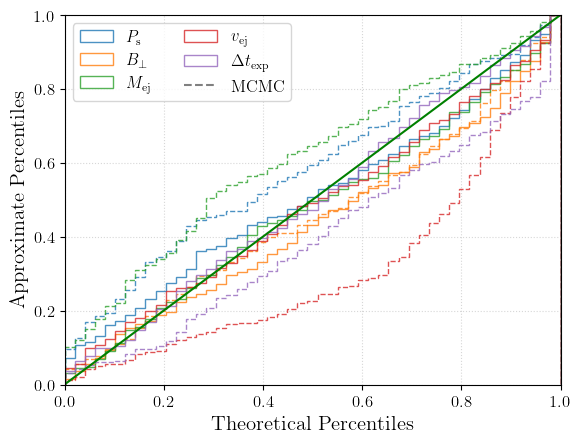

In [98]:
# plt.style.use('ggplot')                                                          
# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# plt.style.use('default')
colors=plt.get_cmap('tab10')
bins=np.linspace(0, 1, num=50)
fancy_labels = [r'$P_{\rm{s}}$', r'$B_{\perp}$', r'$M_{\rm{ej}}$', r'$v_{\rm{ej}}$', r'$\Delta t_{\rm{exp}}$']

for i in range(5):
    plt.hist(all_percentile_sbi_big[:,i]/100, density=True, cumulative=True, label=fancy_labels[i],
            histtype='step', alpha=0.8, bins=bins, color=colors(i))
    # plt.hist(all_percentile_sbi_NE/100, density=True, cumulative=True, label='CDF',
    #          histtype='step', alpha=0.8, bins=50, linestyle=':')
    plt.hist(all_percentile_mcmc[:,i]/100, density=True, cumulative=True,
            histtype='step', alpha=0.8, bins=bins, linestyle='--', color=colors(i))

plt.plot([0,1],[0,1], color='Green')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.gca().add_artist(plt.Line2D([0], [0], color='gray', label='MCMC', linestyle='--'))
plt.legend(ncol=2)
plt.xlabel('Theoretical Percentiles', fontsize=15)
plt.ylabel('Approximate Percentiles', fontsize=15)
plt.grid(alpha=0.5, linestyle=':')
plt.savefig('Figures/pp_plot.pdf', bbox_inches='tight')
plt.show()

# Timing

In [102]:
import time

In [104]:
from interpolate_lcs import *

# Import the LCs
lcs = np.load('data/full_lcs.npz', allow_pickle=True)['lcs']

# Apply a quality cut
lcs_cut = apply_quality_cut(lcs)

# Interpolate each of the lightcurves
start = time.time()
interpolated_lcs = []
for i_lc, lc in enumerate(lcs_cut[:100]):
    interpolated_lcs.append(interpolate_lc(lc))
end = time.time()
print(f'Interpolating takes {(end-start) / 100} per LC.')

Original number of lcs is 66549, quality cut kept 32643
Interpolating takes 0.16132139682769775 per LC.


In [111]:
from autoencode import *

# Load data and normalize
print('Loading data!!!')
lcs, X = load_data()
lc_scaler = StandardScaler()
X_norm = lc_scaler.fit_transform(X)
autoencoder = torch.load('models/tuned_states/autoencoder0.pkl')

# Encode all the lightcurves and save data
print('Encoding!!!')
start = time.time()
X_encoded = autoencoder.encode(torch.tensor(X_norm[:100], dtype=torch.float32)).detach().numpy()
end = time.time()
print(f'Interpolating takes {(end-start) / 100} per LC.')

Loading data!!!
Encoding!!!
Interpolating takes 0.0002591896057128906 per LC.


In [112]:
start = time.time()
for i, X_i in enumerate(X_test[:100]):
    sbi_samples_big.append(hatp_x_y_big.sample((500,), x=X_i).numpy())
end = time.time()
print(f'Interpolating takes {(end-start) / 100} per LC.')

Drawing 500 posterior samples: 636it [00:00, 1650.91it/s]                        
Drawing 500 posterior samples: 537it [00:00, 4808.73it/s]             
Drawing 500 posterior samples: 531it [00:00, 2934.12it/s]                         
Drawing 500 posterior samples: 530it [00:00, 4130.71it/s]             
Drawing 500 posterior samples: 554it [00:00, 5710.50it/s]             
Drawing 500 posterior samples: 558it [00:00, 6520.08it/s]             
Drawing 500 posterior samples: 538it [00:00, 6264.78it/s]             
Drawing 500 posterior samples: 598it [00:00, 7419.09it/s]             
Drawing 500 posterior samples: 606it [00:00, 4878.49it/s]             
Drawing 500 posterior samples: 573it [00:00, 6618.77it/s]             
Drawing 500 posterior samples: 530it [00:00, 6009.62it/s]             
Drawing 500 posterior samples: 566it [00:00, 5253.15it/s]             
Drawing 500 posterior samples: 538it [00:00, 3427.97it/s]                         
Drawing 500 posterior samples: 578it [00:0

Interpolating takes 0.09484660863876343 per LC.


In [113]:
from mcmc import *

# Import the LCs
lcs = np.load('data/full_lcs_interped.npz', allow_pickle=True)['lcs']
lcs = np.array([lc for lc in lcs if np.mean(lc.snrs) > 3])
for lc in lcs:  # adjust the t explosion
    lc.theta[-1] -= min(lc.times)
    lc.theta[-1] *= -1
lcs.shape

# with open('data/full_encoded_lcs.pkl', 'rb') as f:
#     encoded_lcs, lcs = pickle.load(f)

# # Filter for snr > 3
# encoded_lcs     = np.array([e_lc for e_lc, lc in zip(encoded_lcs, lcs) if np.mean(lc.snrs) > 3])
# lcs             = np.array([lc   for e_lc, lc in zip(encoded_lcs, lcs) if np.mean(lc.snrs) > 3])
lcs_train, lcs = train_test_split(lcs, random_state=22, test_size=0.2)
predictor_mask = np.array([ True,  True, False, False, False, False, False,  True,  True, False,  True]) # Mask for theta that only gets what we actually care about
all_predictor_labels = np.array(['pspin', 'bfield', 'mns', 'thetapb', 'texp', 'kappa', 'kappagamma', 'mej', 'vej', 'tfloor', 'texplosion'])
predictor_labels = all_predictor_labels[predictor_mask]
print(f'theta = {predictor_labels}')

# Tensorize the data
ts = [np.array(lc.times) - np.min(lc.times) for lc in lcs]
thetas = torch.tensor([lc.theta for lc in lcs])[:, predictor_mask]
filters = [ugrizy_to_numbers(lc.filters).astype(int) for lc in lcs]
zs = torch.tensor([lc.redshift for lc in lcs]).reshape(-1, 1)
lumdists = cosmo.luminosity_distance(zs)
dist_consts = torch.tensor(np.log10(4. * np.pi * (lumdists.cgs.value) ** 2).reshape(-1, 1))
ys = [torch.tensor(lc.mags) for lc in lcs]
yerrs = [torch.tensor((1/lc.snrs) * lc.mags) for lc in lcs]


nwalkers = 50
p0 = MCMC_PRIOR.sample(sample_shape=torch.Size([50,]))
dtype = [("log_prior", float), ("mean", float)]

# Initialize the sampler
i=0
start = time.time()
sampler = emcee.EnsembleSampler(nwalkers, NUM_PARAMS, log_probability, args=(ts[i], ys[i], yerrs[i], filters[i], zs[i], dist_consts[i]), blobs_dtype=dtype)

# Run 100 burn in steps :)
burn_results = sampler.run_mcmc(p0, 100, progress=True)
sampler.reset()

# Do the final sampling
final_results = sampler.run_mcmc(burn_results, 6000, progress=True)
end = time.time()
print(f'MCMC takes {(end-start)} per LC.')

theta = ['pspin' 'bfield' 'mej' 'vej' 'texplosion']


/Users/adamboesky/Research/SBI_205/models/magnetar_model.py:65: RuntimeWarning: divide by zero encountered in power
  multiplier =  (1.0 - np.exp(-A*test_t**-2)) * np.exp(-(test_t/tau_diff)**2)
/Users/adamboesky/Research/SBI_205/models/magnetar_model.py:61: RuntimeWarning: overflow encountered in exp
  integrand = 2* lum_inp * test_t/tau_diff * np.exp((test_t/tau_diff)**2)  * 1e52
/Users/adamboesky/Research/SBI_205/models/magnetar_model.py:61: RuntimeWarning: overflow encountered in multiply
  integrand = 2* lum_inp * test_t/tau_diff * np.exp((test_t/tau_diff)**2)  * 1e52
/Users/adamboesky/Research/SBI_205/models/magnetar_model.py:66: RuntimeWarning: invalid value encountered in multiply
  l_out = multiplier * cumtrapz(integrand, test_t, initial = 0)
/Users/adamboesky/Research/SBI_205/models/magnetar_model.py:82: RuntimeWarning: overflow encountered in power
  radius = np.sqrt(luminosities / (STEF_CONST * temperature**4))
/Users/adamboesky/Research/SBI_205/models/magnetar_model.py:82: 

MCMC takes 245.33730936050415 per LC.
